In [49]:
#import required packages
#basics
import pandas as pd 
import numpy as np

#misc
import gc
import time
import warnings

#stats
from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss

#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
import matplotlib_venn as venn

#nlp
import string
import re    #for regex
import nltk
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   


#FeatureEngineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

cols_target = ["ABDOMINAL","ADVANCED_CAD","ALCOHOL_ABUSE",
               "ASP_FOR_MI","CREATININE","DIETSUPP_2MOS",
               "DRUG_ABUSE","ENGLISH","HBA1C","KETO_1YR",
               "MAJOR_DIABETES", "MAKES_DECISIONS", "MI_6MOS"]



#settings
start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
eng_stopwords = set(stopwords.words("english"))
warnings.filterwarnings("ignore")

lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

%matplotlib inline

In [50]:
from sklearn.model_selection import train_test_split
df = pd.read_csv('/Users/isabelmetzger/PycharmProjects/json-to-csv/HP_train_df_april20_2018.csv')

#df = pd.read_csv('/Users/isabelmetzger/Documents/2018/n2c2/df_binary_n2c2.csv')
df['id'] = df.index
df.head()

,text,enc_type,file_time,note_csn_id,note_id,note_type,pat_enc_csn_id,pat_id,pat_mrn,tvt_index,py_index,tvt_group,label,index_date,date_eol,flag_eol,days.eol,HP_Note,id
0,I have reviewed the history and physical ? rec...,Hospital Encounter,2016-02-18T17:07:00Z,429261240,519102626,Interval H&P Note,675504043,Z1376416,1297126,4364.0,8998.0,train,0.0,2016-02-18,NaN,NaN,NaN,True,0
1,I have reviewed the history and physical ? rec...,Hospital Encounter,2015-03-24T20:53:00Z,312338595,376960355,Interval H&P Note,543749030,Z3079527,9460512,31644.0,71022.0,train,0.0,2015-03-24,NaN,NaN,NaN,True,1
2,ORTHO H&P Francis Napolitano is a 59 y.o. m...,Hospital Encounter,2015-06-29T14:59:00Z,347094897,418608772,H&P,599298185,Z3555279,9936222,48838.0,102733.0,train,0.0,2015-06-29,NaN,NaN,NaN,True,2
3,I have reviewed the history and physical ? rec...,Hospital Encounter,2016-09-19T15:10:00Z,489540447,585175535,Interval H&P Note,693404963,Z1910753,5211288,9805.0,20167.0,train,0.0,2016-09-19,NaN,NaN,NaN,True,3
4,I have reviewed the history and physical ? rec...,Hospital Encounter,2016-10-25T15:46:00Z,499759507,595169900,Interval H&P Note,693224227,Z3602721,9983654,50573.0,104791.0,train,0.0,2015-10-27,NaN,NaN,NaN,True,4


In [51]:
from sklearn.model_selection import train_test_split


# df.columns =['id','text','ABDOMINAL',
#        'ADVANCED_CAD', 'ALCOHOL_ABUSE', 'ASP_FOR_MI', 'CREATININE',
#        'DIETSUPP_2MOS', 'DRUG_ABUSE', 'ENGLISH', 'HBA1C', 
#        'MAJOR_DIABETES', 'MAKES_DECISIONS', 'MI6_MOS']
cols_target = ['label']
# cols_target = ['ABDOMINAL',
#        'ADVANCED_CAD', 'ALCOHOL_ABUSE', 'ASP_FOR_MI', 'CREATININE',
#        'DIETSUPP_2MOS', 'DRUG_ABUSE', 'ENGLISH', 'HBA1C', 'KETO_1YR',
#        'MAJOR_DIABETES', 'MAKES_DECISIONS', 'MI6_MOS']

msk = np.random.rand(len(df)) < 0.7

train = df[msk]

test = df[~msk]
train.head()

,text,enc_type,file_time,note_csn_id,note_id,note_type,pat_enc_csn_id,pat_id,pat_mrn,tvt_index,py_index,tvt_group,label,index_date,date_eol,flag_eol,days.eol,HP_Note,id
0,I have reviewed the history and physical ? rec...,Hospital Encounter,2016-02-18T17:07:00Z,429261240,519102626,Interval H&P Note,675504043,Z1376416,1297126,4364.0,8998.0,train,0.0,2016-02-18,NaN,NaN,NaN,True,0
2,ORTHO H&P Francis Napolitano is a 59 y.o. m...,Hospital Encounter,2015-06-29T14:59:00Z,347094897,418608772,H&P,599298185,Z3555279,9936222,48838.0,102733.0,train,0.0,2015-06-29,NaN,NaN,NaN,True,2
3,I have reviewed the history and physical ? rec...,Hospital Encounter,2016-09-19T15:10:00Z,489540447,585175535,Interval H&P Note,693404963,Z1910753,5211288,9805.0,20167.0,train,0.0,2016-09-19,NaN,NaN,NaN,True,3
5,I have reviewed the history and physical ? rec...,Hospital Encounter,2016-10-25T15:46:00Z,499759507,595169900,Interval H&P Note,693224227,Z3602721,9983654,50574.0,104792.0,train,0.0,2016-10-25,NaN,NaN,NaN,True,5
7,OB H&P No LMP recorded. Patient is pregnant...,Hospital Encounter,2016-03-31T19:27:00Z,446030582,539679086,H&P,685042617,Z4976753,11356825,65123.0,130833.0,train,0.0,2016-03-31,NaN,NaN,NaN,True,7


In [52]:
train.tail(1)

,text,enc_type,file_time,note_csn_id,note_id,note_type,pat_enc_csn_id,pat_id,pat_mrn,tvt_index,py_index,tvt_group,label,index_date,date_eol,flag_eol,days.eol,HP_Note,id
67018,Feige Klein 9704801 No LMP recorded. Patie...,Hospital Encounter,2016-02-09T23:30:00Z,426223697,515242807,H&P,677801910,Z3323834,9704801,37406.0,89060.0,train,0.0,2016-02-09,NaN,NaN,NaN,True,67018


In [53]:
nrow_train=train.shape[0]
nrow_test=test.shape[0]
sum=nrow_train+nrow_test
print("       : train : test")
print("rows   :",nrow_train,":",nrow_test)
print("perc   :",round(nrow_train*100/sum),"   :",round(nrow_test*100/sum))
train[['id', 'text', 'enc_type', 'note_type', 'label']]

       : train : test
rows   : 46853 : 20166
perc   : 70    : 30


,id,text,enc_type,note_type,label
0,0,I have reviewed the history and physical ? rec...,Hospital Encounter,Interval H&P Note,0.0
2,2,ORTHO H&P Francis Napolitano is a 59 y.o. m...,Hospital Encounter,H&P,0.0
3,3,I have reviewed the history and physical ? rec...,Hospital Encounter,Interval H&P Note,0.0
5,5,I have reviewed the history and physical ? rec...,Hospital Encounter,Interval H&P Note,0.0
7,7,OB H&P No LMP recorded. Patient is pregnant...,Hospital Encounter,H&P,0.0
9,9,OB Triage Note Ann Avouris 9168474 No L...,Hospital Encounter,H&P,0.0
11,11,HISTORY AND PHYSICAL Procedure Date: 8/10/1...,Hospital Encounter,H&P,0.0
12,12,Trauma History and Physical Trauma Activat...,Hospital Encounter,H&P,0.0
13,13,OB H&P Brenda Lieberman 9410772 No LMP ...,Hospital Encounter,H&P,0.0
14,14,I have reviewed the history and physical recor...,Hospital Encounter,H&P,0.0


In [54]:
print("Check for missing values in Train dataset")
null_check=train.isnull().sum()
print(null_check)
train = train[['id', 'text', 'enc_type', 'note_type', 'label']]
print(train.isnull().sum())
print("Check for missing values in Test dataset")
null_check=test.isnull().sum()
print(null_check)
test = test[['id', 'text', 'enc_type', 'note_type', 'label']]
cols_target = ['label']
null_check=test.isnull().sum()
print(null_check)
# ['ABDOMINAL',
#        'ADVANCED_CAD', 'ALCOHOL_ABUSE', 'ASP_FOR_MI', 'CREATININE',
#        'DIETSUPP_2MOS', 'DRUG_ABUSE', 'ENGLISH', 'HBA1C', #'KETO_1YR',
#        'MAJOR_DIABETES', 'MAKES_DECISIONS', 'MI6_MOS']

Check for missing values in Train dataset
text                 26
enc_type              0
file_time             0
note_csn_id           0
note_id               0
note_type             0
pat_enc_csn_id        0
pat_id                0
pat_mrn               0
tvt_index            43
py_index             43
tvt_group            43
label                43
index_date           43
date_eol          44033
flag_eol          44033
days.eol          44033
HP_Note               0
id                    0
dtype: int64
id            0
text         26
enc_type      0
note_type     0
label        43
dtype: int64
Check for missing values in Test dataset
text                 12
enc_type              0
file_time             0
note_csn_id           0
note_id               0
note_type             0
pat_enc_csn_id        0
pat_id                0
pat_mrn               0
tvt_index            22
py_index             22
tvt_group            22
label                22
index_date           22
date_eol          1

In [55]:
#train.iloc[:,1:]
train = train[pd.notnull(train['text'])]
test = test[pd.notnull(test['text'])]
train = train[pd.notnull(train['label'])]
test = test[pd.notnull(test['label'])]

In [56]:
#x=train.iloc[:,1:].sum()

#rowsums=train.iloc[:,1:].sum(axis=1)

#count number of clean entries


# print("Total tags =",x.sum())
null_check=test.isnull().sum()
print(null_check)
null_check=train.isnull().sum()
print(null_check)
print("Total docs = ",len(train))

id           0
text         0
enc_type     0
note_type    0
label        0
dtype: int64
id           0
text         0
enc_type     0
note_type    0
label        0
dtype: int64
Total docs =  46784


In [57]:
# x=train.iloc[:,2:].sum()
# #plot
# sns.set(style="ticks")


# ax=sns.barplot(y = x.index, x = x.values, alpha=0.8, palette="Set3")
# plt.title("# per class")
# plt.ylabel('# of Occurrences', fontsize=12)
# plt.xlabel('Label', fontsize=12)
# plt.title('Number of Occurrences of Label == "met"')
# #adding the text labels
# rects = ax.patches
# labels = x.values
# sns.despine(offset=10, trim=True)
train.head()

,id,text,enc_type,note_type,label
0,0,I have reviewed the history and physical ? rec...,Hospital Encounter,Interval H&P Note,0.0
2,2,ORTHO H&P Francis Napolitano is a 59 y.o. m...,Hospital Encounter,H&P,0.0
3,3,I have reviewed the history and physical ? rec...,Hospital Encounter,Interval H&P Note,0.0
5,5,I have reviewed the history and physical ? rec...,Hospital Encounter,Interval H&P Note,0.0
7,7,OB H&P No LMP recorded. Patient is pregnant...,Hospital Encounter,H&P,0.0


In [58]:
rowsums = train[cols_target].sum()
rowsums

label    995.0
dtype: float64

In [59]:
rowsums.value_counts

<bound method IndexOpsMixin.value_counts of label    995.0
dtype: float64>

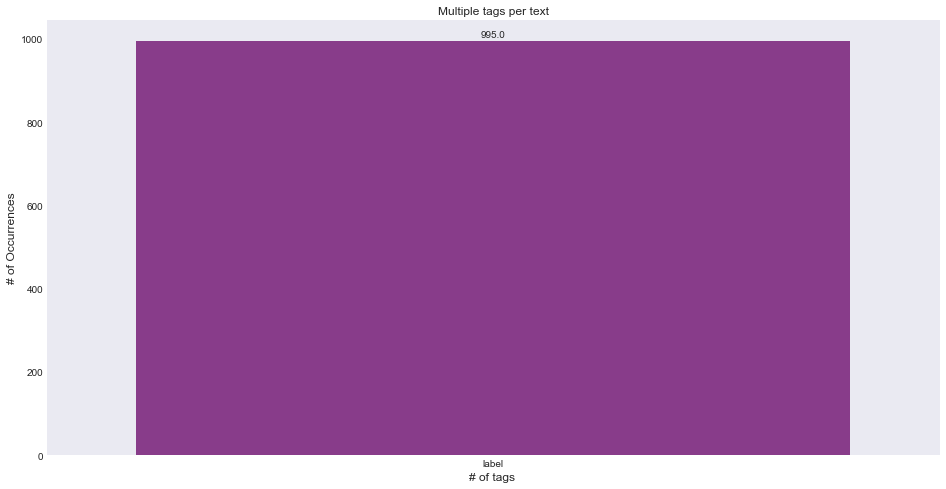

In [60]:
x=rowsums
#plot
plt.figure(figsize=(16,8))
ax = sns.barplot(x.index, x.values, alpha=0.8,color='purple')
plt.title("Multiple tags per text")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of tags ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [61]:
# temp_df=train.iloc[:,2:-1]
# # filter temp by removing clean comments
# # temp_df=temp_df[~train.clean]

# corr=temp_df.corr()
# plt.figure(figsize=(10,8))
# sns.heatmap(corr,
#             xticklabels=corr.columns.values,
#             yticklabels=corr.columns.values, annot=True)

In [62]:
#Crosstab
# Since technically a crosstab between all 6 classes is impossible to vizualize, lets take a 
# look at toxic with other tags
# main_col=""
# corr_mats=[]
# for other_col in temp_df.columns[1:]:
#     confusion_matrix = pd.crosstab(temp_df[main_col], temp_df[other_col])
#     corr_mats.append(confusion_matrix)
# out = pd.concat(corr_mats,axis=1,keys=temp_df.columns[1:])

# #cell highlighting

# out

In [63]:
#https://stackoverflow.com/questions/20892799/using-pandas-calculate-cram%C3%A9rs-coefficient-matrix/39266194
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))


In [64]:
#Checking for Toxic and Severe toxic for now
# import pandas as pd
# col1="ADVANCED_CAD"
# col2="MAJOR_DIABETES"
# confusion_matrix = pd.crosstab(temp_df[col1], temp_df[col2])
# print("Confusion matrix between advanced cad and diabetes:")
# print(confusion_matrix)
# new_corr=cramers_corrected_stat(confusion_matrix)
# print("The correlation betweenadvanced cad and diabetes using Cramer's stat=",new_corr)

In [65]:
print("NOTE WITH LABEL = 1 :\n########################\n")
print(train[train.label==1].iloc[1,1])


NOTE WITH LABEL = 1 :
########################

History of Present Illness: 34 year old male with history significant for CAD s/p CABG and PCI with recent balloon angioplasty on 3/21/16, HFrEF, ESRD on HD and NIDDM complicated by gastroparesis presents with two day history of nausea and vomiting.    The patient was admitted to HCC 11 from 3/21/16 to 3/23/16 after presenting with acute left sided chest pain radiating to back and shoulder, which he described as similar pain to his prior MIs. EKG showed STE in anterior leads and diffse ST depressions, he was taken for cath at STEMI activation and patient underwent balloon angioplasty to ISR of prior LAD stent. Cilostazol and Ranexa were added to his medications for additional anti-anginal effect and the patient was discharged home.    Since discharge he reports feeling well, with improved exercise tolerance, able to walk up to 5 blocks and up the stairs in his home without chest pain or dyspnea. For the past two days, however, the patient

In [66]:
stopword=set(STOPWORDS)

In [67]:
#stopword

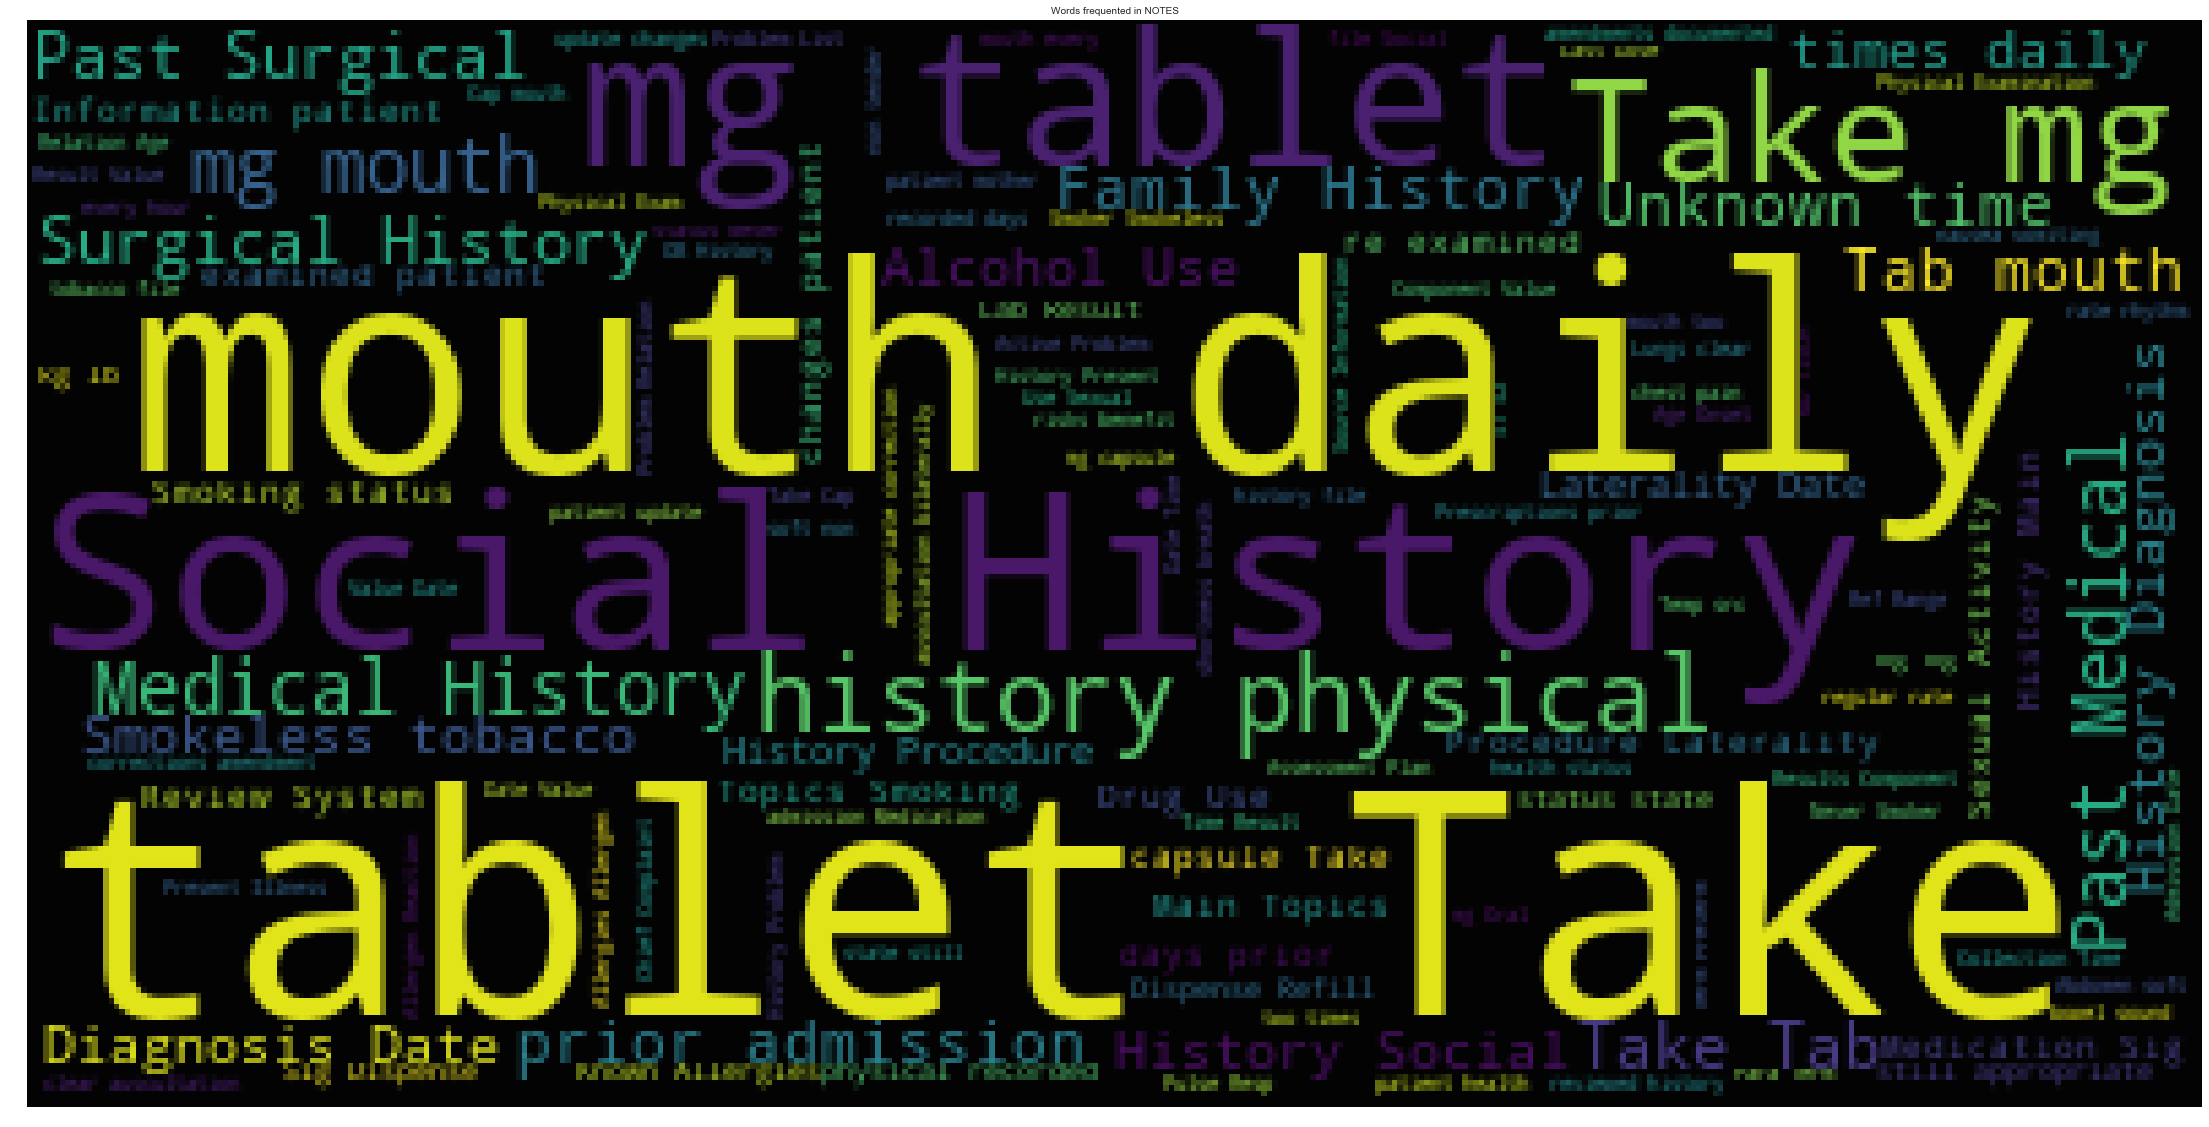

In [68]:

#wordcloud for clean comments

text=train.text.values
wc= WordCloud(background_color="black",max_words=20000,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(40,20))
plt.axis("off")
plt.title("Words frequented in NOTES", fontsize=10)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=2), alpha=0.99)
plt.show()


In [69]:
stopword_w_medical ={'a',
 'about', 'PO', 'QD', 'patient', 'Record',
 'above',
 'after',
 'again',
 'against',
 'all',
 'also',
 'am',
 'an',
 'and',
 'any',
 'are',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 "can't",
 'cannot',
 'com',
 'could',
 "couldn't",
 'did',
 "didn't",
 'do',
 'does',
 "doesn't",
 'doing',
 "don't",
 'down',
 'during',
 'each',
 'else',
 'ever',
 'few',
 'for',
 'from',
 'further',
 'get',
 'had',
 "hadn't",
 'has',
 "hasn't",
 'have',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 "here's",
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 "how's",
 'however',
 'http',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'k',
 "let's",
 'like',
 'me',
 'more',
 'most',
 "mustn't",
 'my',
 'myself',
 'no',
 'nor',
 'not',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'otherwise',
 'ought',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r',
 'same',
 'shall',
 "shan't",
 'she',
 "she'd",
 "she'll",
 "she's",
 'should',
 "shouldn't",
 'since',
 'so',
 'some',
 'such',
 'than',
 'that',
 "that's",
 'the',
 'their',
 'theirs',
 'them',
 'themselves',
 'then',
 'there',
 "there's",
 'these',
 'they',
 "they'd",
 "they'll",
 "they're",
 "they've",
 'this',
 'those',
 'through',
 'to',
 'too',
 'under',
 'until',
 'up',
 'very',
 'was',
 "wasn't",
 'we',
 "we'd",
 "we'll",
 "we're",
 "we've",
 'were',
 "weren't",
 'what',
 "what's",
 'when',
 "when's",
 'where',
 "where's",
 'which',
 'while',
 'who',
 "who's",
 'whom',
 'why',
 "why's",
 'with',
 "won't",
 'would',
 "wouldn't",
 'www',
 'you',
 "you'd",
 "you'll",
 "you're",
 "you've",
 'your',
 'yours',
 'yourself',
 'yourselves', 'will', 'has'}

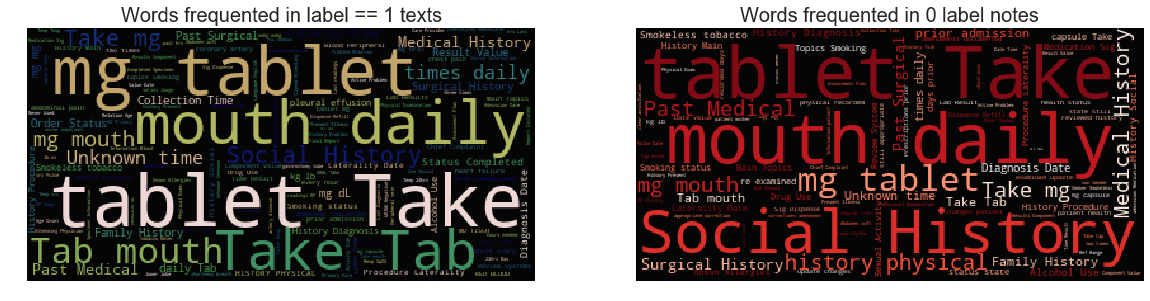

In [70]:
subset=train[train.label==1]
text=subset.text.values
wc= WordCloud(background_color="black",max_words=200,stopwords=stopword_w_medical)
wc.generate(" ".join(text))
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.axis("off")
plt.title("Words frequented in label == 1 texts", fontsize=20)
plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98)


plt.subplot(222)

subset=train[train.label==0]
text=subset.text.values
wc= WordCloud(background_color="black",max_words=200,stopwords=stopword_w_medical)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in 0 label notes", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=244), alpha=0.98)

# #Threat comments
# plt.subplot(223)

# subset=train[train.DRUG_ABUSE==1]
# text=subset.text.values
# wc= WordCloud(background_color="black",max_words=200,stopwords=stopword_w_medical)
# wc.generate(" ".join(text))
# plt.axis("off")
# plt.title("Words frequented in Drug Abuse", fontsize=20)
# plt.imshow(wc.recolor(colormap= 'summer' , random_state=2534), alpha=0.98)

# #insult
# plt.subplot(224)

# subset=train[train.CREATININE==1]
# text=subset.text.values
# wc= WordCloud(background_color="black",max_words=200,stopwords=stopword_w_medical)
# wc.generate(" ".join(text))
# plt.axis("off")
# plt.title("Words frequented in Creatinine Notes", fontsize=20)
# plt.imshow(wc.recolor(colormap= 'Paired_r' , random_state=244), alpha=0.98)

# plt.show()

Feature engineering:¶
I've broadly classified my feature engineering ideas into the following three groups

Direct features:
Features which are a directly due to words/content.We would be exploring the following techniques

Word frequency features
Count features
Bigrams
Trigrams
Vector distance mapping of words (Eg: Word2Vec)
Sentiment scores
Indirect features:
Some more experimental features.

count of sentences
count of words
count of unique words
count of letters
count of punctuations
count of uppercase words/letters
count of stop words
Avg length of each word
Leaky features:
From the example, we know that the comments contain identifier information (eg: age,etc.). We can create features out of them but, it will certainly lead to overfitting to this specific Wikipedia use-case.


Note: Creating the indirect and leaky features first. There are two reasons for this,

Count features(Direct features) are useful only if they are created from a clean corpus
Also the indirect features help compensate for the loss of information when cleaning the dataset

In [81]:
merge=pd.concat([train.iloc[:,0:2],test.iloc[:,0:2]])
merge.head(2)

,id,text
0,0,I have reviewed the history and physical ? rec...
2,2,ORTHO H&P Francis Napolitano is a 59 y.o. m...


In [82]:
merge=pd.concat([train.iloc[:,0:2],test.iloc[:,0:2]])
df=merge.reset_index(drop=True)
# Indirect features

#Sentense count in each comment:
    #  '\n' can be used to count the number of sentences in each comment
#df['count_sent']=df["text"].apply(lambda x: len(re.findall("",str(x)))+1)
#Word count in each comment:
df['count_word']=df["text"].apply(lambda x: len(str(x).split()))
#Unique word count
df['count_unique_word']=df["text"].apply(lambda x: len(set(str(x).split())))
#Letter count
df['count_letters']=df["text"].apply(lambda x: len(str(x)))
#punctuation count
df["count_punctuations"] =df["text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
#upper case words count
df["count_words_upper"] = df["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
#title case words count
df["count_words_title"] = df["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
#Number of stopwords
df["count_stopwords"] = df["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in stopword]))
#Average length of the words
df["mean_word_len"] = df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [73]:
#derived features
#Word count percent in each comment:
df['word_unique_percent']=df['count_unique_word']*100/df['count_word']
#derived features
#Punct percent in each comment:
df['punct_percent']=df['count_punctuations']*100/df['count_word']
#serperate train and test features
train_feats=df.iloc[0:len(train),]
test_feats=df.iloc[len(train):,]
#join the tags
train_tags=train.iloc[:,2:]
train_feats=pd.concat([train_feats,train_tags],axis=1)

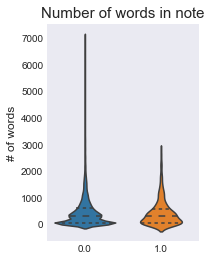

In [83]:

train_feats['count_word'].loc[train_feats['count_word']>50000] = 50000
plt.subplot(122)
sns.violinplot(y='count_word',x='label', data=train_feats,split=True,inner="quart")
plt.xlabel('', fontsize=12)
plt.ylabel('# of words', fontsize=12)
plt.title("Number of words in note", fontsize=15)

plt.show()


In [84]:
train_feats['count_unique_word'].loc[train_feats['count_unique_word']>200]
#prep for split violin plots
#For the desired plots , the data must be in long format
temp_df = pd.melt(train_feats, value_vars=['count_word', 'count_unique_word'], id_vars='DRUG.ABUSE')
#spammers - comments with less than 40% unique words
small_notes_not_unique =train_feats[train_feats['word_unique_percent']<40]


In [85]:
small_notes_not_unique.head()

,id,text,count_word,count_unique_word,count_letters,count_punctuations,count_words_upper,count_words_title,count_stopwords,mean_word_len,word_unique_percent,punct_percent,enc_type,note_type,label
2526,3626.0,NEW CONSULTATION PATIENT NAME: KLOPPENBURG...,1769.0,514.0,11624.0,370.0,142.0,262.0,722.0,5.165630,29.055964,20.915772,Hospital Encounter,H&P,0.0
3482,4943.0,"Scott Marwin, MD NYU ORTHOPAEDIC SURGERY ASSO...",1762.0,644.0,11233.0,279.0,123.0,234.0,571.0,5.259364,36.549376,15.834279,Hospital Encounter,Interval H&P Note,0.0
3590,5109.0,HISTORY AND PHYSICAL Admission Date/Time: 5...,2286.0,905.0,15860.0,1126.0,508.0,423.0,224.0,5.057305,39.588801,49.256343,Hospital Encounter,H&P,0.0
3591,5110.0,HISTORY AND PHYSICAL Admission Date/Time: 5...,2286.0,905.0,15860.0,1126.0,508.0,423.0,224.0,5.057305,39.588801,49.256343,Pre-Procedure Phone Call,H&P,0.0
3592,5112.0,HISTORY AND PHYSICAL Admission Date/Time: 5...,2297.0,912.0,15934.0,1129.0,508.0,427.0,227.0,5.060078,39.703962,49.151067,NaN,NaN,NaN


In [86]:
#

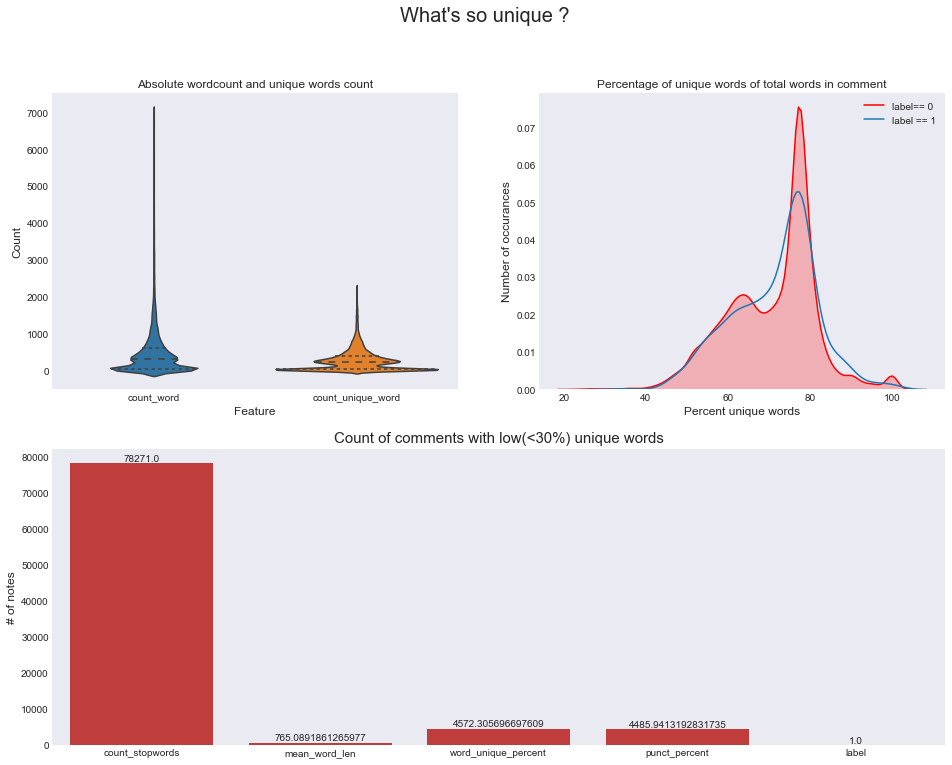

In [87]:
plt.figure(figsize=(16,12))
plt.suptitle("What's so unique ?",fontsize=20)
gridspec.GridSpec(2,2)
plt.subplot2grid((2,2),(0,0))
sns.violinplot(x='variable', y='value', data=temp_df,inner='quartile')
plt.title("Absolute wordcount and unique words count")
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.subplot2grid((2,2),(0,1))
plt.title("Percentage of unique words of total words in comment")
#sns.boxplot(x='clean', y='word_unique_percent', data=train_feats)
ax=sns.kdeplot(train_feats[train_feats.label == 0].word_unique_percent, label="label== 0",shade=True,color='r')
ax=sns.kdeplot(train_feats[train_feats.label == 1].word_unique_percent, label="label == 1")
plt.legend()
plt.ylabel('Number of occurances', fontsize=12)
plt.xlabel('Percent unique words', fontsize=12)

x=small_notes_not_unique.iloc[:,-7:].sum()
plt.subplot2grid((2,2),(1,0),colspan=2)
plt.title("Count of comments with low(<30%) unique words",fontsize=15)
ax=sns.barplot(x=x.index, y=x.values,color=color[3])

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.ylabel('# of notes', fontsize=12)
plt.show()

Word count VS unique word count:
There are noticeable shifts in the mean of both word count and unique word count across clean and toxic comments.

Chart desc: The first chart is a split violin chart. It is a variation of the traditional box chart/violin chart which allows us to split the violin in the middle based on a categorical variable.
Unique word count percent:
There is a bulge near the 0-10% mark which indicates a large number of toxic comments which contain very little variety of words.

Chart desc: The second chart is an overlay of two kernel density estimation plots of percentage of unique words out of all the words in the comment, done for both clean and toxic comments
Even though the number of clean comments dominates the dataset(~90%), there are only 75 clean comments that are spam, which makes it a powerful indicator of a toxic comment.

In [88]:
df["text"][0]

"I have reviewed the history and physical ? recorded 1 to 30 days prior to admission ? and I have re-examined the patient (so as to update any changes in the patient's health status), and I state that it is still appropriate with my corrections and/or amendments as documented."

In [89]:
df["text"].apply(lambda x: re.findall(r"ED|emergency|Emergency|EMERGENCY", str(x)))

0                                                       []
1                                                     [ED]
2                                                       []
3                                                       []
4                                                       []
5                                                       []
6                                                       []
7                                                       []
8                                                       []
9                                                       []
10                                                      []
11                                                      []
12                    [ED, ED, ED, ED, ED, ED, ED, ED, ED]
13                                             [emergency]
14                                             [emergency]
15                                                      []
16                                                      

In [90]:
df["text"].apply(lambda x: re.findall(r"woman|female", str(x)))

0                              []
1                              []
2                              []
3                              []
4                              []
5                              []
6        [female, female, female]
7                [female, female]
8                              []
9                              []
10                             []
11                             []
12                             []
13                             []
14                             []
15                             []
16                             []
17                             []
18                             []
19               [female, female]
20               [female, female]
21                             []
22                             []
23                             []
24                             []
25                             []
26                             []
27                             []
28                             []
29            

In [91]:
df["text"].apply(lambda x: re.findall(r"medication | prescription",str(x)))

0                     []
1                     []
2                     []
3                     []
4                     []
5                     []
6                     []
7                     []
8                     []
9                     []
10                    []
11                    []
12                    []
13       [ prescription]
14       [ prescription]
15                    []
16                    []
17                    []
18         [medication ]
19                    []
20                    []
21                    []
22                    []
23                    []
24                    []
25                    []
26                    []
27                    []
28                    []
29                    []
              ...       
66886                 []
66887                 []
66888                 []
66889                 []
66890      [medication ]
66891      [medication ]
66892                 []
66893    [ prescription]
66894                 []


In [92]:
df["text"][0]
df["text"].apply(lambda x: re.findall(r"\d+\.\d+",str(x)))

0                                                       []
1        [37.9, 100.3, 1.829, 108.863, 39.5, 103.1, 22....
2                                                       []
3                                                       []
4                                             [36.6, 97.9]
5                                             [37.6, 99.7]
6                                                       []
7        [36.5, 97.7, 1.702, 20.36, 4.0, 1.68, 7.7, 28....
8                                                       []
9                                                       []
10                                                      []
11        [36.5, 97.7, 36.5, 97.7, 10.5, 10.8, 33.6, 94.8]
12                                      [0.6, 0.1, 31.746]
13                                                  [77.1]
14                                                  [77.1]
15                                                      []
16                                      [12.5, 12.5, 12.

In [93]:
df["text"].apply(lambda x: re.findall(r"&#(0[0-7]+"
                     "|[0-9]+"
                     "|x[0-9a-fA-F]+);",str(x)))

0        []
1        []
2        []
3        []
4        []
5        []
6        []
7        []
8        []
9        []
10       []
11       []
12       []
13       []
14       []
15       []
16       []
17       []
18       []
19       []
20       []
21       []
22       []
23       []
24       []
25       []
26       []
27       []
28       []
29       []
         ..
66886    []
66887    []
66888    []
66889    []
66890    []
66891    []
66892    []
66893    []
66894    []
66895    []
66896    []
66897    []
66898    []
66899    []
66900    []
66901    []
66902    []
66903    []
66904    []
66905    []
66906    []
66907    []
66908    []
66909    []
66910    []
66911    []
66912    []
66913    []
66914    []
66915    []
Name: text, Length: 66916, dtype: object

In [94]:
df["is_a"]=df["text"].apply(lambda x: re.findall("is a",str(x)))

df["countisa"] = df["is_a"].apply(lambda x: len(x))
                    
                    
df["yr_f"]= df["text"].apply(lambda x: re.findall("yo|y/o|year old|yr old|year-old|yr-old",str(x)))
df['yr_counts'] = df["yr_f"].apply(lambda x: len(x))
df["text"].apply(lambda x: re.findall(r"\d{1,3}\.\d{1,3}",str(x)))

0                                                       []
1        [37.9, 100.3, 1.829, 108.863, 39.5, 103.1, 22....
2                                                       []
3                                                       []
4                                             [36.6, 97.9]
5                                             [37.6, 99.7]
6                                                       []
7        [36.5, 97.7, 1.702, 20.36, 4.0, 1.68, 7.7, 28....
8                                                       []
9                                                       []
10                                                      []
11        [36.5, 97.7, 36.5, 97.7, 10.5, 10.8, 33.6, 94.8]
12                                      [0.6, 0.1, 31.746]
13                                                  [77.1]
14                                                  [77.1]
15                                                      []
16                                      [12.5, 12.5, 12.

In [95]:
df["text"].apply(lambda x: re.findall(r"Pt is a| pt is a| patient is a", str(x)))

0                        []
1                        []
2                        []
3                        []
4        [Pt is a, Pt is a]
5        [Pt is a, Pt is a]
6                        []
7                        []
8        [Pt is a, Pt is a]
9                        []
10                       []
11                       []
12                       []
13          [ patient is a]
14          [ patient is a]
15                       []
16                       []
17                       []
18                       []
19                       []
20                       []
21                       []
22                       []
23                       []
24                       []
25                       []
26                       []
27                       []
28                       []
29                       []
                ...        
66886       [ patient is a]
66887                    []
66888    [Pt is a, Pt is a]
66889                    []
66890               

In [96]:
#Leaky features
df['record_d'] =df["text"].apply(lambda x: re.findall(r"Record date:", str(x)))
df['count_rec']=df["record_d"].apply(lambda x: len(x))


df['fem_gender'] =df["text"].apply(lambda x: re.findall(r"woman|female", str(x)))
df['count_wom']=df["fem_gender"].apply(lambda x: len(x))


df['er_mention'] = df["text"].apply(lambda x: re.findall(r"ED|emergency|Emergency|EMERGENCY", str(x)))
df['count_er_mention']=df["er_mention"].apply(lambda x: len(x))


df['alcohol_mention'] = df["text"].apply(lambda x: re.findall(r"EtOH", str(x)))
# df['ip']=df["text"].apply(lambda x: re.findall("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}",str(x)))
df['count_alcohol_mention']=df["alcohol_mention"].apply(lambda x: len(x))

df["gender_male"]=df["text"].apply(lambda x: re.findall(r"male|man",str(x)))
df['count_gender_male']=df["gender_male"].apply(lambda x: len(x))

#article ids
df['adverg']=df["text"].apply(lambda x: re.findall(r"\w+ly",str(x)))
df['article_id_adverb']=df.adverg.apply(lambda x: len(x))

#username
##              regex for     Match anything with [[User: ---------- ]]
df["defiingpatients"]= df["text"].apply(lambda x: re.findall(r"Pt is a| pt is a| patient is a", str(x)))
df["dates"]=df["text"].apply(lambda x: re.findall(r'(\d+/\d+/\d+)',str(x)))
df["dates_counts"]=df["dates"].apply(lambda x: len(x))


df['digits_labs']=df["text"].apply(lambda x: re.findall(r"\d+\.\d+",str(x)))
df['count_digits']=df["digits_labs"].apply(lambda x: len(x))

df['medications_rx']=df["text"].apply(lambda x: re.findall(r"medication | prescription",str(x)))
df['medications_rx_count']=df["medications_rx"].apply(lambda x: len(x))
df['u']=df["text"].apply(lambda x: re.findall(r"&#(0[0-7]+"
                     "|[0-9]+"
                     "|x[0-9a-fA-F]+);",str(x)))

df['u_count']=df["u"].apply(lambda x: len(x))
df['a1c']=df["text"].apply(lambda x: re.findall(r"a1c|A1C", str(x)))
df['count_a1c']=df["a1c"].apply(lambda x: len(x))
#check if features are created


# Leaky Ip
cv = CountVectorizer()
count_feats_ip = cv.fit_transform(df["defiingpatients"].apply(lambda x : str(x)))



# Leaky usernames

cv = CountVectorizer()
count_feats_user = cv.fit_transform(df["digits_labs"].apply(lambda x : str(x)))
df[df.medications_rx_count!=0].text.iloc[0]

"Columbus Cardiology Associates  Luciano Del Guzzo MD  555 Madison Ave.  2nd Floor  New York, NY 10022  Tel:  (212) 263-0116  Fax: (646) 501-0047    8/23/2016      John Bernaudo  2/27/1954    John Bernaudo  is a 62 y.o.male who presents for cardiac evaluation because of a history of recurrent left foot ulcers due to a Charcot joint with collapse of ankle bones. He has treated these ulcers over the past 2-3 years with conservative measures and occasionally required debridement by Dr. Jessica Galena (foot and ankle orthopedics). He last saw HER-2 years ago. Recently the left ankle has collapsed and resulted in a severe varus deformity of the ankle and foot which led to ulceration of the external and posterior aspect of the foot. The patient has tried treating this at home but tells me that he now can feel bone at the bottom of the ulcer. He is not in pain and has had a low-grade temperature without fever or chills or night sweats. His temperature in the evening is 99-100. There has been 

In [97]:
cv.get_feature_names()[120:130]


['103', '1037', '104', '105', '1054', '106', '1069', '107', '108', '109']

In [98]:
df.columns

Index(['id', 'text', 'count_word', 'count_unique_word', 'count_letters',
       'count_punctuations', 'count_words_upper', 'count_words_title',
       'count_stopwords', 'mean_word_len', 'is_a', 'countisa', 'yr_f',
       'yr_counts', 'record_d', 'count_rec', 'fem_gender', 'count_wom',
       'er_mention', 'count_er_mention', 'alcohol_mention',
       'count_alcohol_mention', 'gender_male', 'count_gender_male', 'adverg',
       'article_id_adverb', 'defiingpatients', 'dates', 'dates_counts',
       'digits_labs', 'count_digits', 'medications_rx', 'medications_rx_count',
       'u', 'u_count', 'a1c', 'count_a1c'],
      dtype='object')

In [99]:
df[df.count_a1c!=0].text.iloc[0]

'MEDICINE INPATIENT H&P    Patient Language: English                Interpreter: Not needed  Accompanied by:     Chief Complaint   Patient presents with   ? Leg Pain     Pt aao x3 with c/o bi-lateral leg pain x1 day and chills. Pt denies         HPI:   Mary Asaro is a 63 y.o. female with history of HLD, OSA (noncompliant with CPAP), obesity, who presented to ED this morning with lower right leg pain, redness and swelling.  Patient states she woke up this morning with fever, chills, muscle aches, nausea with 3 episodes of NBNB vomiting.  Patient also reports a nonproductive cough for past 7 days due to a "cold".  Patient has had multiple episodes of cellulitis over the past 3 years. Patient denies SOB, chest pain, runny nose, sore throat, abdominal pain, diarrhea, constipation.    In the ED, vital signs significant for temp of 102.8F, HR 126, BP 157/96, SpO2 95%.  Labs were significant for WBC of 14.7, lactate 2.0-->1.7.   Patient received tylenol and 2g Vancomycin IV in ED, plus 30 cc/

In [100]:

df.u[df.u_count>0]


Series([], Name: u, dtype: object)

In [101]:
leaky_feats=df[['is_a', 'countisa', 'yr_f',
       'yr_counts', 'record_d', 'count_rec', 'fem_gender', 'count_wom',
       'er_mention', 'count_er_mention', 'alcohol_mention',
       'count_alcohol_mention', 'gender_male', 'count_gender_male', 'adverg',
       'article_id_adverb', 'defiingpatients', 'dates', 'dates_counts',
       'digits_labs', 'count_digits', 'medications_rx', 'medications_rx_count',
       'u', 'u_count', 'a1c', 'count_a1c']]
leaky_feats_train=leaky_feats.iloc[:train.shape[0]]
leaky_feats_test=leaky_feats.iloc[train.shape[0]:]
#filterout the entries without ips
train_ips=leaky_feats_train.digits_labs[leaky_feats_train.count_digits!=0]
test_ips=leaky_feats_test.digits_labs[leaky_feats_test.count_digits!=0]
#get the unique list of ips in test and train datasets
train_ip_list=list(set([a for b in train_ips.tolist() for a in b]))
test_ip_list=list(set([a for b in test_ips.tolist() for a in b]))

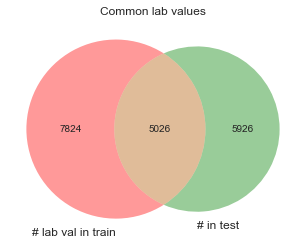

In [102]:

# get common elements
common_ip_list=list(set(train_ip_list).intersection(test_ip_list))
plt.title("Common lab values")
venn.venn2(subsets=(len(train_ip_list),len(test_ip_list),len(common_ip_list)),set_labels=("# lab val in train","# in test"))
plt.show()

In [103]:
leaky_feats_test.u[leaky_feats_test.u_count!=0]

Series([], Name: u, dtype: object)

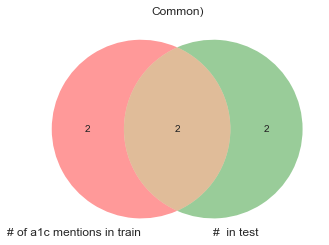

In [104]:

train_links=leaky_feats_train.a1c[leaky_feats_train.count_a1c!=0]
test_links=leaky_feats_test.a1c[leaky_feats_test.count_a1c!=0]
#get the unique list of ips in test and train datasets
train_links_list=list(set([a for b in train_links.tolist() for a in b]))
test_links_list=list(set([a for b in test_links.tolist() for a in b]))

# get common elements
common_links_list=list(set(train_links_list).intersection(test_links_list))
plt.title("Common)")
venn.venn2(subsets=(len(train_links_list),len(test_links_list),len(common_links_list)),
           set_labels=("# of a1c mentions in train","#  in test"))
plt.show()

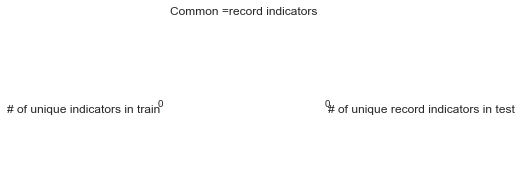

In [105]:
#filterout the entries without users
train_users=leaky_feats_train.u[leaky_feats_train.u_count!=0]
test_users=leaky_feats_test.u[leaky_feats_test.u_count!=0]
#get the unique list of ips in test and train datasets
train_users_list=list(set([a for b in train_users.tolist() for a in b]))
test_users_list=list(set([a for b in test_users.tolist() for a in b]))

# get common elements
common_users_list=list(set(train_users_list).intersection(test_users_list))
plt.title("Common =record indicators")
venn.venn2(subsets=(len(train_users_list),len(test_users_list),len(common_users_list)),
           set_labels=("# of unique indicators in train","# of unique record indicators in test"))
plt.show()

In [106]:
corpus=merge.text

In [107]:
#https://drive.google.com/file/d/0B1yuv8YaUVlZZ1RzMFJmc1ZsQmM/view
# Aphost lookup dict
APPO = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"
}

In [ ]:
def clean(comment):
    """
    This function receives comments and returns clean word-list
    """
    #Convert to lower case comment=comment.lower()
    #remove \n
    comment=re.sub(r"\\n","",comment)
    comment=re.sub(r"(?<=[a-z])[@13!]+(?=[a-z])","", comment)
    # remove leaky elements 
    #comment=re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",comment)
    #comment=re.sub("\[\[.*\]","",comment)
    
    #Split the sentences into words
    words=tokenizer.tokenize(comment)
    
    # (')aphostophe  replacement (ie)   you're --> you are  
    # ( basic dictionary lookup : master dictionary present in a hidden block of code)
    words=[APPO[word] if word in APPO else word for word in words]
    words=[lem.lemmatize(word, "v") for word in words]
    words = [w for w in words if not w in eng_stopwords]
    
    clean_sent=" ".join(words)
    # remove any non alphanum,digit character
    #clean_sent=re.sub("\W+"," ",clean_sent)
    #clean_sent=re.sub("  "," ",clean_sent)
    return(clean_sent)


In [ ]:
clean(corpus.iloc[12])
TARGET_COLS = ['label']

TARGET_COLS=['ABDOMINAL',
       'ADVANCED_CAD', 'ALCOHOL_ABUSE', 'ASP_FOR_MI', 'CREATININE',
       'DIETSUPP_2MOS', 'DRUG_ABUSE', 'ENGLISH', 'HBA1C', 
       'MAJOR_DIABETES', 'MAKES_DECISIONS', 'MI6_MOS']

In [ ]:
clean_corpus=corpus.apply(lambda x :clean(x))

end_time=time.time()
print("total time till Cleaning",end_time-start_time)

Direct features:
1)Count based features(for unigrams):
Lets create some features based on frequency distribution of the words. Initially lets consider taking words one at a time (ie) Unigrams

Python's SKlearn provides 3 ways of creating count features.All three of them first create a vocabulary(dictionary) of words and then create a sparse matrix of word counts for the words in the sentence that are present in the dictionary. A brief description of them:

CountVectorizer
Creates a matrix with frequency counts of each word in the text corpus
TF-IDF Vectorizer
TF - Term Frequency -- Count of the words(Terms) in the text corpus (same of Count Vect)
IDF - Inverse Document Frequency -- Penalizes words that are too frequent. We can think of this as regularization
HashingVectorizer
Creates a hashmap(word to number mapping based on hashing technique) instead of a dictionary for vocabulary
This enables it to be more scalable and faster for larger text coprus
Can be parallelized across multiple threads
Using TF-IDF here. Note: Using the concatenated dataframe "merge" which contains both text from train and test dataset to ensure that the vocabulary that we create does not missout on the words that are unique to testset.



In [ ]:
start_unigrams=time.time()

tfv = TfidfVectorizer(min_df=200,  max_features=1000, 
            strip_accents='unicode', analyzer='word',ngram_range=(1,1),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')
tfv.fit(clean_corpus)
features = np.array(tfv.get_feature_names())

train_unigrams =  tfv.transform(clean_corpus.iloc[:train.shape[0]])
test_unigrams = tfv.transform(clean_corpus.iloc[train.shape[0]:])

In [ ]:
train_unigrams

In [ ]:
#https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=15):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(Xtr, features, grp_ids, min_tfidf=0.1, top_n=15):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    
    D = Xtr[grp_ids].toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

# modified for multilabel milticlass
def top_feats_by_class(Xtr, features, min_tfidf=0.1, top_n=15):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    cols=train_tags.columns
    for col in cols:
        ids = train_tags.index[train_tags[col]==1]
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [ ]:
top_tfidf_feats(test_unigrams, features)

In [ ]:
plt.figure(figsize=(16,22))
plt.suptitle("TF_IDF Top words per class(unigrams)",fontsize=20)
gridspec.GridSpec(4,2)
plt.subplot2grid((4,2),(0,0))
sns.barplot(tfidf_top_n_per_lass[0].feature.iloc[0:9],tfidf_top_n_per_lass[0].tfidf.iloc[0:9],color=color[0])
plt.title("class : Toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.subplot2grid((4,2),(0,1))
sns.barplot(tfidf_top_n_per_lass[1].feature.iloc[0:9],tfidf_top_n_per_lass[1].tfidf.iloc[0:9],color=color[1])
plt.title("class : Severe toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,0))
sns.barplot(tfidf_top_n_per_lass[2].feature.iloc[0:9],tfidf_top_n_per_lass[2].tfidf.iloc[0:9],color=color[2])
plt.title("class : Obscene",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,1))
sns.barplot(tfidf_top_n_per_lass[3].feature.iloc[0:9],tfidf_top_n_per_lass[3].tfidf.iloc[0:9],color=color[3])
plt.title("class : Threat",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,0))
sns.barplot(tfidf_top_n_per_lass[4].feature.iloc[0:9],tfidf_top_n_per_lass[4].tfidf.iloc[0:9],color=color[4])
plt.title("class : Insult",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,1))
sns.barplot(tfidf_top_n_per_lass[5].feature.iloc[0:9],tfidf_top_n_per_lass[5].tfidf.iloc[0:9],color=color[5])
plt.title("class : Identity hate",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(3,0),colspan=2)
sns.barplot(tfidf_top_n_per_lass[6].feature.iloc[0:19],tfidf_top_n_per_lass[6].tfidf.iloc[0:19])
plt.title("class : Clean",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.show()

In [ ]:
#temp settings to min=150 to facilitate top features section to run in kernals
#change back to min=10 to get better results
tfv = TfidfVectorizer(min_df=150,  max_features=30000, 
            strip_accents='unicode', analyzer='word',ngram_range=(2,2),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

tfv.fit(clean_corpus)
features = np.array(tfv.get_feature_names())
train_bigrams =  tfv.transform(clean_corpus.iloc[:train.shape[0]])
test_bigrams = tfv.transform(clean_corpus.iloc[train.shape[0]:])
#get top n for bigrams
tfidf_top_n_per_lass=top_feats_by_class(train_bigrams,features)
plt.figure(figsize=(16,22))
plt.suptitle("TF_IDF Top words per class(Bigrams)",fontsize=20)
gridspec.GridSpec(4,2)
plt.subplot2grid((4,2),(0,0))
sns.barplot(tfidf_top_n_per_lass[0].feature.iloc[0:5],tfidf_top_n_per_lass[0].tfidf.iloc[0:5],color=color[0])
plt.title("class : ",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.subplot2grid((4,2),(0,1))
sns.barplot(tfidf_top_n_per_lass[1].feature.iloc[0:5],tfidf_top_n_per_lass[1].tfidf.iloc[0:5],color=color[1])
plt.title("class : ",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,0))
sns.barplot(tfidf_top_n_per_lass[2].feature.iloc[0:5],tfidf_top_n_per_lass[2].tfidf.iloc[0:5],color=color[2])
plt.title("class :",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,1))
sns.barplot(tfidf_top_n_per_lass[3].feature.iloc[0:5],tfidf_top_n_per_lass[3].tfidf.iloc[0:5],color=color[3])
plt.title("class :",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,0))
sns.barplot(tfidf_top_n_per_lass[4].feature.iloc[0:5],tfidf_top_n_per_lass[4].tfidf.iloc[0:5],color=color[4])
plt.title("class : Insult",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,1))
sns.barplot(tfidf_top_n_per_lass[5].feature.iloc[0:5],tfidf_top_n_per_lass[5].tfidf.iloc[0:5],color=color[5])
plt.title("class : Identity hate",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(3,0),colspan=2)
sns.barplot(tfidf_top_n_per_lass[6].feature.iloc[0:9],tfidf_top_n_per_lass[6].tfidf.iloc[0:9])
plt.title("class : Clean",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.show()

In [ ]:
tfv = TfidfVectorizer(min_df=100,  max_features=30000, 
            strip_accents='unicode', analyzer='char',ngram_range=(1,4),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

tfv.fit(clean_corpus)
features = np.array(tfv.get_feature_names())
train_charngrams =  tfv.transform(clean_corpus.iloc[:train.shape[0]])
test_charngrams = tfv.transform(clean_corpus.iloc[train.shape[0]:])
end_time=time.time()
print("total time till charngrams",end_time-start_time)

In [ ]:
#Credis to AlexSanchez https://www.kaggle.com/jhoward/nb-svm-strong-linear-baseline-eda-0-052-lb#261316
#custom NB model

class NbSvmClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, dual=False, n_jobs=1):
        self.C = C
        self.dual = dual
        self.n_jobs = n_jobs

    def predict(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict(x.multiply(self._r))

    def predict_proba(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict_proba(x.multiply(self._r))

    def fit(self, x, y):
        # Check that X and y have correct shape
        y = y.values
        x, y = check_X_y(x, y, accept_sparse=True)

        def pr(x, y_i, y):
            p = x[y==y_i].sum(0)
            return (p+1) / ((y==y_i).sum()+1)

        self._r = sparse.csr_matrix(np.log(pr(x,1,y) / pr(x,0,y)))
        x_nb = x.multiply(self._r)
        self._clf = LogisticRegression(C=self.C, dual=self.dual, n_jobs=self.n_jobs).fit(x_nb, y)
        return self
    
# model = NbSvmClassifier(C=4, dual=True, n_jobs=-1)

In [ ]:
SELECTED_COLS=['count_sent', 'count_word', 'count_unique_word',
       'count_letters', 'count_punctuations', 'count_words_upper',
       'count_words_title', 'count_stopwords', 'mean_word_len',
       'word_unique_percent', 'punct_percent']
target_x = train_feats[SELECTED_COLS]
# target_x

TARGET_COLS=['ABDOMINAL',
       'ADVANCED_CAD', 'ALCOHOL_ABUSE', 'ASP_FOR_MI', 'CREATININE',
       'DIETSUPP_2MOS', 'ENGLISH', 'HBA1C', 
       'MAJOR_DIABETES', 'MAKES_DECISIONS', 'MI6_MOS']
target_y=train_tags[TARGET_COLS]

# Strat k fold due to imbalanced classes
# split = StratifiedKFold(n_splits=2, random_state=1)

#https://www.kaggle.com/yekenot/toxic-regression;l
len(target_y)
print(len(target_x), len(target_y))

In [ ]:
train_bigrams

In [ ]:
#Just the indirect features -- meta features
print("Using only Indirect features")
model = LogisticRegression(C=3)
X_train, X_valid, y_train, y_valid = train_test_split(train_bigrams, target_y, test_size=0.3, random_state=2018)
train_loss = []
valid_loss = []
importance=[]
preds_train = np.zeros((X_train.shape[0], len(y_train)))
preds_valid = np.zeros((X_valid.shape[0], len(y_valid)))
for i, j in enumerate(TARGET_COLS):
    print('Class:= '+j)
    model.fit(X_train,y_train[j])
    preds_valid[:,i] = model.predict_proba(X_valid)[:,1]
    preds_train[:,i] = model.predict_proba(X_train)[:,1]
    train_loss_class=log_loss(y_train[j],preds_train[:,i])
    valid_loss_class=log_loss(y_valid[j],preds_valid[:,i])
    print('Trainloss=log loss:', train_loss_class)
    print('Validloss=log loss:', valid_loss_class)
    importance.append(model.coef_)
    train_loss.append(train_loss_class)
    valid_loss.append(valid_loss_class)
print('mean column-wise log loss:Train dataset', np.mean(train_loss))
print('mean column-wise log loss:Validation dataset', np.mean(valid_loss))

end_time=time.time()
print("total time till Indirect feat model",end_time-start_time)

In [ ]:
importance[0][0]

In [ ]:
plt.figure(figsize=(16,22))
plt.suptitle("Feature importance for indirect features",fontsize=20)
gridspec.GridSpec(3,2)
plt.subplots_adjust(hspace=0.4)
plt.subplot2grid((3,2),(0,0))
sns.barplot(SELECTED_COLS,importance[0][0],color=color[0])
plt.title("class : Toxic",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)

plt.subplot2grid((3,2),(0,1))
sns.barplot(SELECTED_COLS,importance[1][0],color=color[1])
plt.title("class : Severe toxic",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)

plt.subplot2grid((3,2),(1,0))
sns.barplot(SELECTED_COLS,importance[2][0],color=color[2])
plt.title("class : Obscene",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)



plt.subplot2grid((3,2),(1,1))
sns.barplot(SELECTED_COLS,importance[3][0],color=color[3])
plt.title("class : Threat",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)


plt.subplot2grid((3,2),(2,0))
sns.barplot(SELECTED_COLS,importance[4][0],color=color[4])
plt.title("class : Insult",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)


plt.subplot2grid((3,2),(2,1))
sns.barplot(SELECTED_COLS,importance[5][0],color=color[5])
plt.title("class : Identity hate",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)


# plt.subplot2grid((4,2),(3,0),colspan=2)
# sns.barplot(SELECTED_COLS,importance[6][0],color=color[0])
# plt.title("class : Clean",fontsize=15)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)
# plt.xlabel('Feature', fontsize=12)
# plt.ylabel('Importance', fontsize=12)

plt.show()


In [ ]:
plt.figure(figsize=(16,22))
plt.suptitle("Feature importance for indirect features",fontsize=20)
gridspec.GridSpec(3,2)
plt.subplots_adjust(hspace=0.4)
plt.subplot2grid((3,2),(0,0))
sns.barplot(SELECTED_COLS,importance[0][0],color=color[0])
plt.title("class : Toxic",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)

plt.subplot2grid((3,2),(0,1))
sns.barplot(SELECTED_COLS,importance[1][0],color=color[1])
plt.title("class : Severe toxic",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)

plt.subplot2grid((3,2),(1,0))
sns.barplot(SELECTED_COLS,importance[2][0],color=color[2])
plt.title("class : Obscene",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)



plt.subplot2grid((3,2),(1,1))
sns.barplot(SELECTED_COLS,importance[3][0],color=color[3])
plt.title("class : Threat",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)


plt.subplot2grid((3,2),(2,0))
sns.barplot(SELECTED_COLS,importance[4][0],color=color[4])
plt.title("class : Insult",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)


plt.subplot2grid((3,2),(2,1))
sns.barplot(SELECTED_COLS,importance[5][0],color=color[5])
plt.title("class : Identity hate",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)


# plt.subplot2grid((4,2),(3,0),colspan=2)
# sns.barplot(SELECTED_COLS,importance[6][0],color=color[0])
# plt.title("class : Clean",fontsize=15)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)
# plt.xlabel('Feature', fontsize=12)
# plt.ylabel('Importance', fontsize=12)

plt.show()


In [ ]:
model = NbSvmClassifier(C=4, dual=True, n_jobs=-1)
X_train, X_valid, y_train, y_valid = train_test_split(train_charngrams, target_y, test_size=0.3, random_state=2018)
train_loss = []
valid_loss = []
preds_train = np.zeros((X_train.shape[0], len(y_train)))
preds_valid = np.zeros((X_valid.shape[0], len(y_valid)))
for i, j in enumerate(TARGET_COLS):
    print('Class:= '+j)
    model.fit(X_train,y_train[j])
    preds_valid[:,i] = model.predict_proba(X_valid)[:,1]
    preds_train[:,i] = model.predict_proba(X_train)[:,1]
    train_loss_class=log_loss(y_train[j],preds_train[:,i])
    valid_loss_class=log_loss(y_valid[j],preds_valid[:,i])
    print('Trainloss=log loss:', train_loss_class)
    print('Validloss=log loss:', valid_loss_class)
    train_loss.append(train_loss_class)
    valid_loss.append(valid_loss_class)
print('mean column-wise log loss:Train dataset', np.mean(train_loss))
print('mean column-wise log loss:Validation dataset', np.mean(valid_loss))


end_time=time.time()
print("total time till NB base model creation",end_time-start_time)